In [24]:
import pandas as pd
df = pd.read_csv("/home/marko/projects/tf216/pgdata.CSV")

In [25]:
df = df.rename(columns={'STN---': 'STN', 'WBAN ': 'WBAN', ' YEARMODA': 'DATE', '   TEMP': 'TEMP', '  ': 'NTEMP', '   DEWP': 'DEWP', '  .1': 'NDEWP',
       '  SLP  ': 'SLP', '  .2': 'NSLP', '  STP  ': 'STP', '  .3': 'NSTP', ' VISIB': 'VSB', '  .4': 'NVSB', '  WDSP': 'WDSP',
       '  .5': 'NWDSP', ' MXSPD': 'MXSPD', '  GUST': 'GUST', '   MAX  ': 'MAXT', '  MIN  ': 'MINT', 'PRCP  ': 'PRCP', 'SNDP ': 'SNDP',
       ' FRSHTT': 'FRSHTT'})


In [26]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%Y%m%d")

In [27]:
all_dates = pd.date_range(start=df["DATE"].min(), end=df["DATE"].max(), freq="D")
df = df.set_index("DATE")
df = df.reindex(all_dates)
df = df.reset_index()
df = df.rename(columns={"index": "DATE"})

In [28]:
df["MAXT"] = pd.to_numeric(df["MAXT"].astype(str).str.replace("*", "", regex=False), errors="coerce")
df["MINT"] = pd.to_numeric(df["MINT"].astype(str).str.replace("*", "", regex=False), errors="coerce")
df['PRCP'] = df['PRCP'].str.replace(r'[A-Z]$', '', regex=True).astype(float)

In [29]:
import numpy as np
df['WBAN'] = df['WBAN'].replace(99999.0, np.nan)
df['DEWP'] = df['DEWP'].replace(9999.9, np.nan)
df['SLP'] = df['SLP'].replace(9999.9, np.nan)
df['STP'] = df['STP'].replace(9999.9, np.nan)
df['WDSP'] = df['WDSP'].replace(999.9, np.nan)
df['MXSPD'] = df['MXSPD'].replace(999.9, np.nan)
df['GUST'] = df['GUST'].replace(999.9, np.nan)
df['PRCP'] = df['PRCP'].replace(99.9, np.nan)
df['SNDP'] = df['SNDP'].replace(999.9, np.nan)

In [30]:

print(df.isna().sum())

DATE         0
STN        362
WBAN      6210
TEMP       362
NTEMP      362
DEWP       363
NDEWP      362
SLP        365
NSLP       362
STP        364
NSTP       362
VSB        362
NVSB       362
WDSP       466
NWDSP      362
MXSPD      610
GUST      6175
MAXT       362
MINT       362
PRCP       362
SNDP      6135
FRSHTT     362
dtype: int64


In [31]:
df.drop(['WBAN', 'GUST', 'SNDP', 'STN'], axis=1, inplace=True)

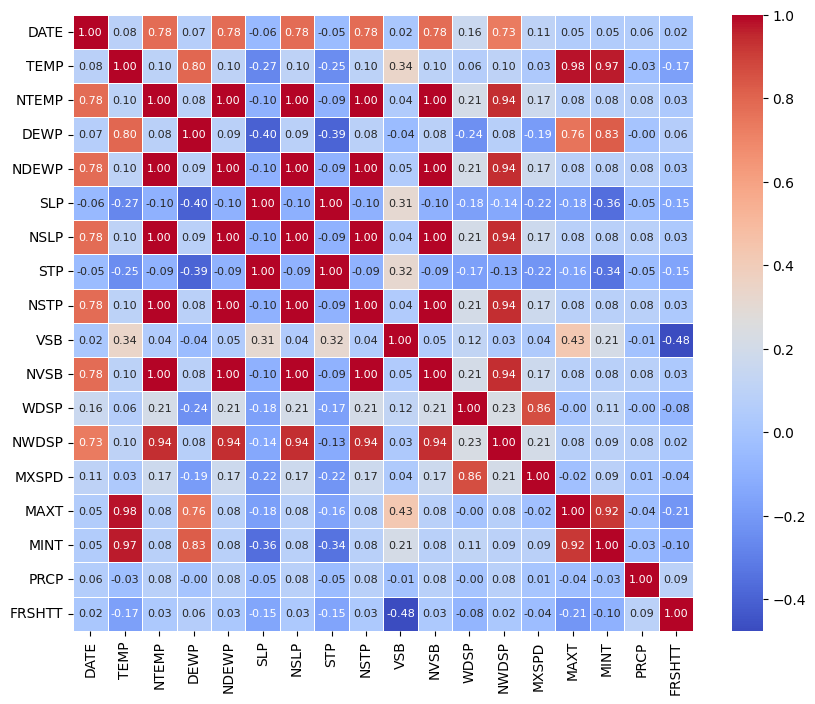

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, annot_kws={"size": 8}) 
plt.show()

In [33]:
for col in ['TEMP', 'MAXT', 'MINT']:
    print(f"Correlations for {col}:")
    print(correlation_matrix[col].abs().sort_values(ascending=False), "\n")

Correlations for TEMP:
TEMP      1.000000
MAXT      0.979968
MINT      0.967413
DEWP      0.796466
VSB       0.341422
SLP       0.268961
STP       0.250753
FRSHTT    0.170836
NWDSP     0.104726
NSLP      0.101142
NDEWP     0.101051
NSTP      0.099968
NVSB      0.099803
NTEMP     0.099681
DATE      0.083968
WDSP      0.064618
MXSPD     0.034286
PRCP      0.029653
Name: TEMP, dtype: float64 

Correlations for MAXT:
MAXT      1.000000
TEMP      0.979968
MINT      0.915695
DEWP      0.756537
VSB       0.425078
FRSHTT    0.212652
SLP       0.179201
STP       0.161290
NDEWP     0.079088
NSLP      0.079037
NSTP      0.077862
NVSB      0.077858
NTEMP     0.077669
NWDSP     0.075488
DATE      0.052574
PRCP      0.035712
MXSPD     0.023445
WDSP      0.000342
Name: MAXT, dtype: float64 

Correlations for MINT:
MINT      1.000000
TEMP      0.967413
MAXT      0.915695
DEWP      0.825182
SLP       0.359172
STP       0.342360
VSB       0.212966
WDSP      0.114379
FRSHTT    0.098557
NWDSP     0.092440

In [34]:
df.drop(['NTEMP', 'NDEWP', 'SLP', 'NSLP', 'NSTP', 'FRSHTT', 'NVSB', 'NWDSP', 'PRCP', 'STP', 'VSB', 'MXSPD'], axis=1, inplace=True)

In [35]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df.loc[df.index.year == df.index.year.min()] = df.loc[df.index.year == df.index.year.min()].interpolate(method='linear')
for col in ['TEMP', 'MINT', 'MAXT', 'DEWP', 'WDSP']:
   df[col] = df.apply(lambda row: 
                       df[(df.index.day == row.name.day) & (df.index.month == row.name.month) & 
                          (df.index.year < row.name.year)][col].mean() 
                       if pd.isna(row[col]) else row[col], axis=1)
df = df.reset_index().rename(columns={"index": "DATE"})

In [36]:
for col in ['TEMP', 'MINT', 'MAXT', 'DEWP', 'WDSP']:
    df[col] = df[col].interpolate(method='linear', limit_direction='forward', axis=0)

In [37]:
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)


Empty DataFrame
Columns: [DATE, TEMP, DEWP, WDSP, MAXT, MINT]
Index: []


In [38]:

for col in ['TEMP', 'MINT', 'MAXT', 'DEWP', 'WDSP']:
    df[col] = df[col].round(1)
    
for col in ['TEMP', 'MINT', 'MAXT', 'DEWP']:
    df[col] = (df[col] - 32) * 5/9
    df[col] = df[col].round(1)
    

df['WDSP'] = df['WDSP'] * 0.514444
df['WDSP'] = df['WDSP'].round(1)
    
def vapor_pressure(T):
    return 6.112 * np.exp((17.62 * T) / (243.12 + T))

df['DEWP'] = vapor_pressure(df['DEWP']) / vapor_pressure(df['TEMP'])
df = df.rename(columns={'DEWP': 'RHUM'})
df['WDSP'] = df['WDSP'].round(3)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6210 entries, 0 to 6209
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    6210 non-null   datetime64[ns]
 1   TEMP    6210 non-null   float64       
 2   RHUM    6210 non-null   float64       
 3   WDSP    6210 non-null   float64       
 4   MAXT    6210 non-null   float64       
 5   MINT    6210 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 291.2 KB


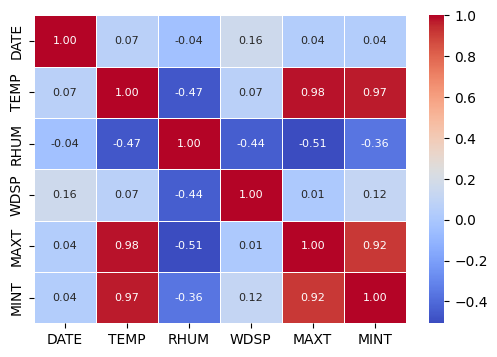

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, annot_kws={"size": 8}) 
plt.show()

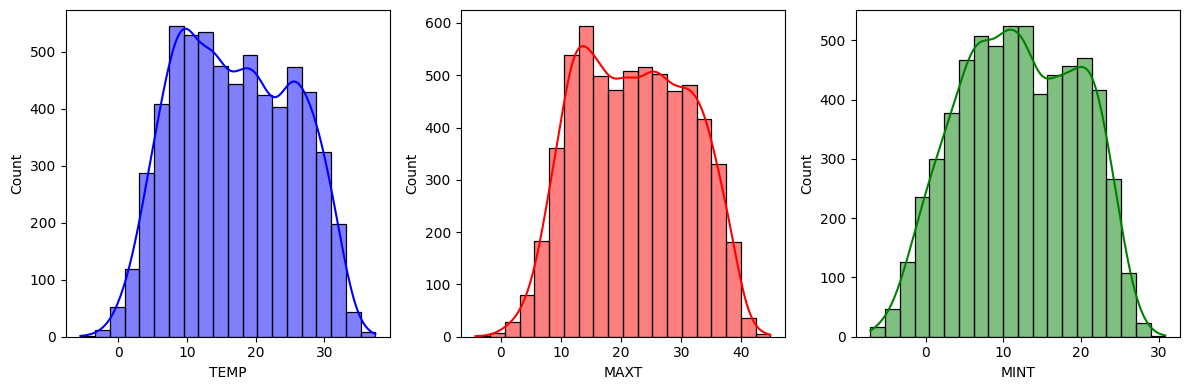

In [41]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(df['TEMP'], bins=20, kde=True, color='blue')

plt.subplot(1, 3, 2)
sns.histplot(df['MAXT'], bins=20, kde=True, color='red')

plt.subplot(1, 3, 3)
sns.histplot(df['MINT'], bins=20, kde=True, color='green')

plt.tight_layout()
plt.show()

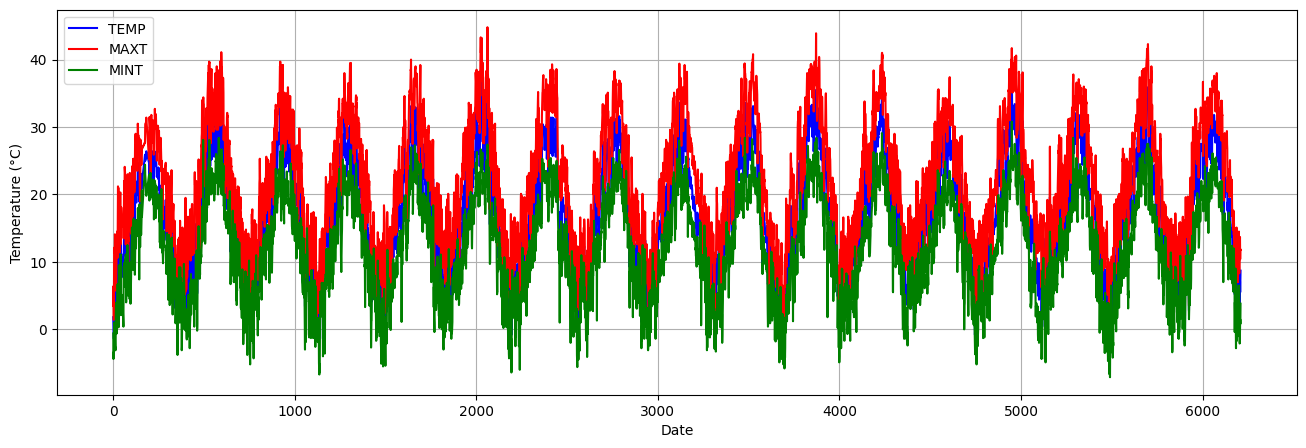

In [42]:
plt.figure(figsize=(16, 5))
plt.plot(df.index, df['TEMP'], label='TEMP', color='blue')
plt.plot(df.index, df['MAXT'], label='MAXT', color='red')
plt.plot(df.index, df['MINT'], label='MINT', color='green')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.show()

In [43]:
df.to_csv("pgdatafinal.csv", index=False)